In [ ]:
# --- Setup ---
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/Shareddrives/BioSCape_Landcover_CNN/capstone_fall_2025"

 3.-NATIONAL-NCA-FORUM-LANDCOVER-2024-08-07-1.pdf   shapefile_jpg
 random_samples					    test_set.csv
 random_samples.zip				    test_set.gsheet
 results_temp					    train_set.csv
'sample_boxes_shapefile (Unzipped Files)'	    train_set.gsheet
 sample_boxes_shapefile.zip			    updated_labels


In [ ]:
# --- Load data ---
# Replace with your paths or use from google.colab import files; files.upload()
EMBED_PATH = '/content/drive/Shareddrives/BioSCape_Landcover_CNN/capstone_fall_2025/results_temp/embedding_px_old.csv'
TRAIN_PATH  = '/content/drive/Shareddrives/BioSCape_Landcover_CNN/capstone_fall_2025/train_set.csv'      # your train_set (with Sample_num + label column)
TEST_PATH = '/content/drive/Shareddrives/BioSCape_Landcover_CNN/capstone_fall_2025/test_set.csv'

df = pd.read_csv(EMBED_PATH)
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

In [ ]:
print(train)

      Sample_num                FinalClass
0              2     Unconsolidated Barren
1              3     Unconsolidated Barren
2              4  Annual Crops (e.g wheat)
3              5  Annual Crops (e.g wheat)
4              6  Annual Crops (e.g wheat)
...          ...                       ...
1936       28460                  Wetlands
1937       28469   Mixed or Not Classified
1938       28480                  Wetlands
1939       28494                  Wetlands
1940       28497   Mixed or Not Classified

[1941 rows x 2 columns]


In [ ]:
print(test)

     Sample_num                FinalClass
0             1     Unconsolidated Barren
1             7  Annual Crops (e.g wheat)
2             8  Annual Crops (e.g wheat)
3            12  Annual Crops (e.g wheat)
4            17  Annual Crops (e.g wheat)
..          ...                       ...
476       28310                  Wetlands
477       28374                  Wetlands
478       28413                  Wetlands
479       28496                  Wetlands
480       28499       Natural Wooded Land

[481 rows x 2 columns]


In [ ]:
print(df)

                  system:index       A00       A01       A02       A03  \
0       000000000000000003f0_0  0.179377 -0.008858 -0.079723 -0.206936   
1       000000000000000003f0_1  0.179377 -0.008858 -0.079723 -0.206936   
2       000000000000000003f0_2  0.179377 -0.015748 -0.084214 -0.206936   
3       000000000000000003f0_3  0.179377 -0.027128 -0.084214 -0.199862   
4       000000000000000003f0_4  0.179377 -0.027128 -0.079723 -0.206936   
...                        ...       ...       ...       ...       ...   
73003  000000000000000003da_25 -0.022207 -0.084214  0.119093  0.010396   
73004  000000000000000003da_26 -0.038447 -0.088827  0.130165  0.035433   
73005  000000000000000003da_27 -0.038447 -0.088827  0.130165  0.035433   
73006  000000000000000003da_28 -0.048228 -0.088827  0.124567  0.038447   
73007  000000000000000003da_29 -0.075356 -0.113741  0.130165  0.051734   

            A04       A05       A06       A07       A08  ...  \
0     -0.071111 -0.160000 -0.084214  0.221453  

In [ ]:
import pandas as pd

# Preserve first 65 fields (A0 - A64) & Smpl_nm
subset = pd.concat([df.iloc[:, :65], df.iloc[:, [72]]], axis=1)

# Rename 'smpl_num' to 'sample_num' if it exists
subset = subset.rename(columns={'Smpl_nm': 'Sample_num'})

# Save the updated CSV
subset.to_csv('embeddings.csv', index=False)

embeddings_df = subset
embeddings_df.to_csv('/content/drive/Shareddrives/BioSCape_Landcover_CNN/capstone_fall_2025/results_temp/embeddings_concat.csv', index=False)

In [ ]:
# Merge labels with training data
merged_df = pd.merge(embeddings_df, train, on='Sample_num', how='left')
filtered_df = merged_df[
    (merged_df['FinalClass'].notna()) &
    (merged_df['FinalClass'] != 'Mixed or Not Classified')
]

# Check the result
print(filtered_df.head())

# Save to CSV
filtered_df.to_csv('/content/drive/Shareddrives/BioSCape_Landcover_CNN/capstone_fall_2025/results_temp/trainingdata_labeled.csv', index=False)

             system:index       A00       A01       A02       A03       A04  \
0  000000000000000003f0_0  0.179377 -0.008858 -0.079723 -0.206936 -0.071111   
1  000000000000000003f0_1  0.179377 -0.008858 -0.079723 -0.206936 -0.071111   
2  000000000000000003f0_2  0.179377 -0.015748 -0.084214 -0.206936 -0.071111   
3  000000000000000003f0_3  0.179377 -0.027128 -0.084214 -0.199862 -0.071111   
4  000000000000000003f0_4  0.179377 -0.027128 -0.079723 -0.206936 -0.075356   

        A05       A06       A07       A08  ...       A56       A57       A58  \
0 -0.160000 -0.084214  0.221453  0.044844  ... -0.124567  0.032541 -0.135886   
1 -0.160000 -0.084214  0.221453  0.044844  ... -0.124567  0.032541 -0.135886   
2 -0.160000 -0.084214  0.206936  0.048228  ... -0.135886  0.022207 -0.135886   
3 -0.186082 -0.108512  0.206936  0.059116  ... -0.130165  0.004983 -0.135886   
4 -0.192910 -0.103406  0.199862  0.062991  ... -0.130165  0.000984 -0.130165   

        A59       A60       A61       A62   

In [ ]:
# Merge labels with testing data
merged_df_test = pd.merge(embeddings_df, test, on='Sample_num', how='left')
filtered_df_test = merged_df_test[
    (merged_df_test['FinalClass'].notna()) &
    (merged_df_test['FinalClass'] != 'Mixed or Not Classified')
]

# Check the result
print(filtered_df_test.head())

# Save to CSV
filtered_df_test.to_csv('/content/drive/Shareddrives/BioSCape_Landcover_CNN/capstone_fall_2025/results_temp/testdata_labeled.csv', index=False)

               system:index       A00       A01       A02       A03       A04  \
150  000000000000000003b6_0  0.160000 -0.004983 -0.012057 -0.199862 -0.088827   
151  000000000000000003b6_1  0.166336  0.007443 -0.015748 -0.186082 -0.071111   
152  000000000000000003b6_2  0.166336  0.007443 -0.015748 -0.186082 -0.071111   
153  000000000000000003b6_3  0.160000  0.004983 -0.017778 -0.179377 -0.071111   
154  000000000000000003b6_4  0.153787  0.003014 -0.035433 -0.172795 -0.059116   

          A05       A06       A07       A08  ...       A56       A57  \
150 -0.199862 -0.066990  0.259900  0.103406  ... -0.038447 -0.027128   
151 -0.186082 -0.075356  0.251965  0.124567  ... -0.044844 -0.024606   
152 -0.186082 -0.075356  0.251965  0.124567  ... -0.044844 -0.024606   
153 -0.192910 -0.075356  0.259900  0.130165  ... -0.041584 -0.027128   
154 -0.206936 -0.093564  0.259900  0.130165  ... -0.035433 -0.027128   

          A58       A59       A60       A61       A62       A63  Sample_num  \
1

In [ ]:
# # Prep training csv
# # Preserve first 65 fields (A0 - A64) & Smpl_nm
# subset = pd.concat([df.iloc[:, :65], df.iloc[:, [72]]], axis=1)

# # Rename 'smpl_num' to 'sample_num' if it exists
# subset = subset.rename(columns={'Smpl_nm': 'Sample_num'})

# # Save the updated CSV
# subset.to_csv('embeddings.csv', index=False)

# embeddings_df = subset
# # Merge labels with training data
# merged_df = pd.merge(embeddings_df, train, on='Sample_num', how='left')
# filtered_df = merged_df[
#     (merged_df['FinalClass'].notna()) &
#     (merged_df['FinalClass'] != 'Mixed or Not Classified')
# ].copy()

In [ ]:
# # Prep testing csv
# # Preserve first 65 fields (A0 - A64) & Smpl_nm
# subset = pd.concat([df.iloc[:, :65], df.iloc[:, [72]]], axis=1)

# # Rename 'smpl_num' to 'sample_num' if it exists
# subset = subset.rename(columns={'Smpl_nm': 'Sample_num'})

# # Save the updated CSV
# subset.to_csv('embeddings.csv', index=False)

# embeddings_df = subset
# # Merge labels with training data
# merged_df_test = pd.merge(embeddings_df, train, on='Sample_num', how='left')
# filtered_df_test = merged_df_test[
#     (merged_df_test['FinalClass'].notna()) &
#     (merged_df_test['FinalClass'] != 'Mixed or Not Classified')
# ].copy()

In [ ]:
import re
import numpy as np
import pandas as pd

from sklearn.covariance import LedoitWolf
from sklearn.decomposition import PCA

# ---------------- CONFIG ----------------
ENABLE_PCA   = True    # set False to skip PCA
N_COMPONENTS = 8       # k << ~30 pixels per shape
ROBUST_Z     = 7     # robust “sigma” threshold for outliers in each shape
# ----------------------------------------

df_in = filtered_df.copy()

# Robust grouping key
df_in["Sample_num"] = df_in["Sample_num"].astype(str).str.replace(r"\.0$", "", regex=True)

# Identify embedding columns A00..A63
EMB_COLS = sorted([c for c in df_in.columns if re.fullmatch(r"A\d{2}", c)])
assert len(EMB_COLS) == 64, f"Expected 64 embedding dims, found {len(EMB_COLS)}"

# Matrix of all embeddings
X_all = df_in[EMB_COLS].to_numpy(dtype=float)

# Optional PCA for stability and noise reduction
if ENABLE_PCA:
    pca = PCA(n_components=N_COMPONENTS, svd_solver="auto", random_state=0)
    Z_all = pca.fit_transform(X_all)  # (N, k)
    k = Z_all.shape[1]
else:
    Z_all = X_all
    k = Z_all.shape[1]

# Attach Z to the frame to avoid re-transforming later
Z_cols = [f"Z{str(i).zfill(2)}" for i in range(k)]
dfZ = pd.DataFrame(Z_all, index=df_in.index, columns=Z_cols)
df_in = pd.concat([df_in, dfZ], axis=1)

# ---- Per-class covariance (LedoitWolf) in Z-space ----
precisions_class = {}
for cls, sub in df_in.groupby("FinalClass"):
    Z_sub = sub[Z_cols].to_numpy()
    # Guard against tiny classes
    if Z_sub.shape[0] < k + 2:
        # fall back on global later
        continue
    lw = LedoitWolf().fit(Z_sub)
    precisions_class[cls] = lw.precision_

# Global fallback covariance if a class is too small
lw_global = LedoitWolf().fit(Z_all)
Prec_global = lw_global.precision_


def mahal_d2_to_group_mean_Z(g: pd.DataFrame) -> pd.DataFrame:
    """
    For one shape (one Sample_num), compute squared Mahalanobis distances in Z-space
    to the shape's mean, using the per-class precision matrix when available.
    Drop only those pixels that are robust outliers within that shape.
    """
    # If the group is very small, don't try to be clever: keep everything
    if g.shape[0] < 5:
        out = g.copy()
        out["mahalanobis_sq"] = 0.0
        return out

    Zg = g[Z_cols].to_numpy()
    mu = Zg.mean(axis=0, keepdims=True)      # (1, k)
    Zc = Zg - mu                             # (n, k)

    cls = g["FinalClass"].iloc[0]
    Prec = precisions_class.get(cls, Prec_global)

    # d^2 = (z - μ)^T Prec (z - μ)
    d2 = np.einsum("ij,jk,ik->i", Zc, Prec, Zc)

    # Robust shape-level threshold: median + ROBUST_Z * MAD
    med = np.median(d2)
    mad = np.median(np.abs(d2 - med))
    # If MAD is zero (all nearly identical), don't drop anything
    if mad == 0 or not np.isfinite(mad):
        keep = np.ones_like(d2, dtype=bool)
    else:
        z_robust = np.abs(d2 - med) / (mad + 1e-12)
        keep = z_robust <= ROBUST_Z

    out = g.loc[keep].copy()
    out["mahalanobis_sq"] = d2[keep]
    return out


# ---- Apply per shape ----
clean_df = (
    df_in
    .groupby("Sample_num", group_keys=False)
    .apply(lambda g: mahal_d2_to_group_mean_Z(g).assign(Sample_num=g.name))
    .reset_index(drop=True)
)

# ---- QA summary (before vs after) ----
before = (
    df_in
    .groupby(["Sample_num", "FinalClass"])
    .size()
    .rename("n_before")
    .to_frame()
)

after = (
    clean_df
    .groupby(["Sample_num", "FinalClass"])
    .size()
    .rename("n_after")
    .to_frame()
)

qa_summary = (
    before.join(after, how="left")
    .fillna({"n_after": 0})
    .astype({"n_before": int, "n_after": int})
    .assign(
        dropped_pixels=lambda x: x["n_before"] - x["n_after"],
        kept_pixels=lambda x: x["n_after"],
        kept_ratio=lambda x: x["n_after"] / x["n_before"]
    )
    .reset_index()
)

# Per-shape mean after filtering (for downstream classification)
per_shape_mean = (
    clean_df
    .groupby(["Sample_num", "FinalClass"], as_index=False)[EMB_COLS]
    .mean()
)

# ---- Some quick prints ----
print(qa_summary.head())
total_before = qa_summary["n_before"].sum()
total_after  = qa_summary["n_after"].sum()
total_dropped = total_before - total_after

print("Total dropped pixels:", total_dropped)
num_boxes_2plus = (qa_summary["dropped_pixels"] >= 2).sum()
print("Number of boxes with 2 or more dropped pixels:", num_boxes_2plus)
num_boxes_3plus = (qa_summary["dropped_pixels"] >= 3).sum()
print("Number of boxes with 3 or more dropped pixels:", num_boxes_3plus)
num_boxes_4plus = (qa_summary["dropped_pixels"] >= 4).sum()
print("Number of boxes with 4 or more dropped pixels:", num_boxes_4plus)
num_boxes_5plus = (qa_summary["dropped_pixels"] >= 5).sum()
print("Number of boxes with 5 or more dropped pixels:", num_boxes_5plus)
boxes_5plus = qa_summary[qa_summary["dropped_pixels"] >= 5]
print(boxes_5plus)
print(f"Total before filtering: {total_before}")
print(f"Total after filtering:  {total_after}")
print(f"Total dropped pixels:   {total_dropped}")

# Optionally save to CSV
clean_df.to_csv('/content/drive/Shareddrives/BioSCape_Landcover_CNN/capstone_fall_2025/results_temp/cleandf_train.csv', index=False)


/tmp/ipython-input-3466295114.py:97: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: mahal_d2_to_group_mean_Z(g).assign(Sample_num=g.name))


  Sample_num                FinalClass  n_before  n_after  dropped_pixels  \
0         10  Annual Crops (e.g wheat)        30       30               0   
1      10046               Waterbodies        31       31               0   
2      10104               Waterbodies        30       29               1   
3      10163               Waterbodies        31       31               0   
4      10171               Waterbodies        30       30               0   

   kept_pixels  kept_ratio  
0           30    1.000000  
1           31    1.000000  
2           29    0.966667  
3           31    1.000000  
4           30    1.000000  
Total dropped pixels: 1065
Number of boxes with 2 or more dropped pixels: 285
Number of boxes with 3 or more dropped pixels: 136
Number of boxes with 4 or more dropped pixels: 61
Number of boxes with 5 or more dropped pixels: 20
     Sample_num                              FinalClass  n_before  n_after  \
65        10701                             Waterbodies 

In [ ]:
# ---------------- CONFIG ----------------
ENABLE_PCA   = True    # set False to skip PCA
N_COMPONENTS = 8       # k << ~30 pixels per shape
ROBUST_Z     = 7     # robust “sigma” threshold for outliers in each shape
# ----------------------------------------

df_in_test = filtered_df_test.copy()

# Robust grouping key
df_in_test["Sample_num"] = df_in_test["Sample_num"].astype(str).str.replace(r"\.0$", "", regex=True)

# Identify embedding columns A00..A63
EMB_COLS = sorted([c for c in df_in_test.columns if re.fullmatch(r"A\d{2}", c)])
assert len(EMB_COLS) == 64, f"Expected 64 embedding dims, found {len(EMB_COLS)}"

# Matrix of all embeddings
X_all = df_in_test[EMB_COLS].to_numpy(dtype=float)

# Optional PCA for stability and noise reduction
if ENABLE_PCA:
    pca = PCA(n_components=N_COMPONENTS, svd_solver="auto", random_state=0)
    Z_all = pca.fit_transform(X_all)  # (N, k)
    k = Z_all.shape[1]
else:
    Z_all = X_all
    k = Z_all.shape[1]

# Attach Z to the frame to avoid re-transforming later
Z_cols = [f"Z{str(i).zfill(2)}" for i in range(k)]
dfZ = pd.DataFrame(Z_all, index=df_in_test.index, columns=Z_cols)
df_in_test = pd.concat([df_in_test, dfZ], axis=1)

# ---- Per-class covariance (LedoitWolf) in Z-space ----
precisions_class = {}
for cls, sub in df_in_test.groupby("FinalClass"):
    Z_sub = sub[Z_cols].to_numpy()
    # Guard against tiny classes
    if Z_sub.shape[0] < k + 2:
        # fall back on global later
        continue
    lw = LedoitWolf().fit(Z_sub)
    precisions_class[cls] = lw.precision_

# Global fallback covariance if a class is too small
lw_global = LedoitWolf().fit(Z_all)
Prec_global = lw_global.precision_


def mahal_d2_to_group_mean_Z(g: pd.DataFrame) -> pd.DataFrame:
    """
    For one shape (one Sample_num), compute squared Mahalanobis distances in Z-space
    to the shape's mean, using the per-class precision matrix when available.
    Drop only those pixels that are robust outliers within that shape.
    """
    # If the group is very small, don't try to be clever: keep everything
    if g.shape[0] < 5:
        out = g.copy()
        out["mahalanobis_sq"] = 0.0
        return out

    Zg = g[Z_cols].to_numpy()
    mu = Zg.mean(axis=0, keepdims=True)      # (1, k)
    Zc = Zg - mu                             # (n, k)

    cls = g["FinalClass"].iloc[0]
    Prec = precisions_class.get(cls, Prec_global)

    # d^2 = (z - μ)^T Prec (z - μ)
    d2 = np.einsum("ij,jk,ik->i", Zc, Prec, Zc)

    # Robust shape-level threshold: median + ROBUST_Z * MAD
    med = np.median(d2)
    mad = np.median(np.abs(d2 - med))
    # If MAD is zero (all nearly identical), don't drop anything
    if mad == 0 or not np.isfinite(mad):
        keep = np.ones_like(d2, dtype=bool)
    else:
        z_robust = np.abs(d2 - med) / (mad + 1e-12)
        keep = z_robust <= ROBUST_Z

    out = g.loc[keep].copy()
    out["mahalanobis_sq"] = d2[keep]
    return out


# ---- Apply per shape ----
clean_df_test = (
    df_in_test
    .groupby("Sample_num", group_keys=False)
    .apply(lambda g: mahal_d2_to_group_mean_Z(g).assign(Sample_num=g.name))
    .reset_index(drop=True)
)

# ---- QA summary (before vs after) ----
before = (
    df_in_test
    .groupby(["Sample_num", "FinalClass"])
    .size()
    .rename("n_before")
    .to_frame()
)

after = (
    clean_df_test
    .groupby(["Sample_num", "FinalClass"])
    .size()
    .rename("n_after")
    .to_frame()
)

qa_summary = (
    before.join(after, how="left")
    .fillna({"n_after": 0})
    .astype({"n_before": int, "n_after": int})
    .assign(
        dropped_pixels=lambda x: x["n_before"] - x["n_after"],
        kept_pixels=lambda x: x["n_after"],
        kept_ratio=lambda x: x["n_after"] / x["n_before"]
    )
    .reset_index()
)

# Per-shape mean after filtering (for downstream classification)
per_shape_mean = (
    clean_df_test
    .groupby(["Sample_num", "FinalClass"], as_index=False)[EMB_COLS]
    .mean()
)

# ---- Some quick prints ----
print(qa_summary.head())
total_before = qa_summary["n_before"].sum()
total_after  = qa_summary["n_after"].sum()
total_dropped = total_before - total_after

print("Total dropped pixels:", total_dropped)
num_boxes_2plus = (qa_summary["dropped_pixels"] >= 2).sum()
print("Number of boxes with 2 or more dropped pixels:", num_boxes_2plus)
num_boxes_3plus = (qa_summary["dropped_pixels"] >= 3).sum()
print("Number of boxes with 3 or more dropped pixels:", num_boxes_3plus)
num_boxes_4plus = (qa_summary["dropped_pixels"] >= 4).sum()
print("Number of boxes with 4 or more dropped pixels:", num_boxes_4plus)
num_boxes_5plus = (qa_summary["dropped_pixels"] >= 5).sum()
print("Number of boxes with 5 or more dropped pixels:", num_boxes_5plus)
boxes_5plus = qa_summary[qa_summary["dropped_pixels"] >= 5]
print(boxes_5plus)
print(f"Total before filtering: {total_before}")
print(f"Total after filtering:  {total_after}")
print(f"Total dropped pixels:   {total_dropped}")

# Optionally save to CSV
clean_df_test.to_csv('/content/drive/Shareddrives/BioSCape_Landcover_CNN/capstone_fall_2025/results_temp/cleandf_test.csv', index=False)

/tmp/ipython-input-1468195652.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: mahal_d2_to_group_mean_Z(g).assign(Sample_num=g.name))


  Sample_num             FinalClass  n_before  n_after  dropped_pixels  \
0          1  Unconsolidated Barren        28       26               2   
1      10095            Waterbodies        31       29               2   
2      10141            Waterbodies        31       31               0   
3      10223            Waterbodies        30       30               0   
4      10358            Waterbodies        30       30               0   

   kept_pixels  kept_ratio  
0           26    0.928571  
1           29    0.935484  
2           31    1.000000  
3           30    1.000000  
4           30    1.000000  
Total dropped pixels: 234
Number of boxes with 2 or more dropped pixels: 66
Number of boxes with 3 or more dropped pixels: 26
Number of boxes with 4 or more dropped pixels: 12
Number of boxes with 5 or more dropped pixels: 2
    Sample_num FinalClass  n_before  n_after  dropped_pixels  kept_pixels  \
253       5696   Built-up        30       25               5           25   
36

In [ ]:
print(filtered_df)

                  system:index       A00       A01       A02       A03  \
0       000000000000000003f0_0  0.179377 -0.008858 -0.079723 -0.206936   
1       000000000000000003f0_1  0.179377 -0.008858 -0.079723 -0.206936   
2       000000000000000003f0_2  0.179377 -0.015748 -0.084214 -0.206936   
3       000000000000000003f0_3  0.179377 -0.027128 -0.084214 -0.199862   
4       000000000000000003f0_4  0.179377 -0.027128 -0.079723 -0.206936   
...                        ...       ...       ...       ...       ...   
72942  00000000000000000362_25 -0.017778 -0.130165  0.214133  0.027128   
72943  00000000000000000362_26 -0.048228 -0.147697  0.199862  0.041584   
72944  00000000000000000362_27 -0.048228 -0.147697  0.199862  0.041584   
72945  00000000000000000362_28 -0.088827 -0.179377  0.172795  0.098424   
72946  00000000000000000362_29 -0.108512 -0.179377  0.160000  0.103406   

            A04       A05       A06       A07       A08  ...       A56  \
0     -0.071111 -0.160000 -0.084214  

In [ ]:
filtered_df = clean_df
filtered_df_test = clean_df_test
print(filtered_df)

                  system:index       A00       A01       A02       A03  \
0       00000000000000000008_0 -0.160000  0.113741  0.135886  0.135886   
1       00000000000000000008_1 -0.153787  0.108512  0.141730  0.147697   
2       00000000000000000008_2 -0.153787  0.108512  0.135886  0.141730   
3       00000000000000000008_3 -0.141730  0.119093  0.135886  0.141730   
4       00000000000000000008_4 -0.147697  0.119093  0.135886  0.141730   
...                        ...       ...       ...       ...       ...   
43621  000000000000000005eb_24 -0.019931 -0.088827 -0.141730 -0.124567   
43622  000000000000000005eb_25 -0.019931 -0.088827 -0.141730 -0.124567   
43623  000000000000000005eb_26 -0.010396 -0.088827 -0.135886 -0.124567   
43624  000000000000000005eb_28 -0.010396 -0.093564 -0.141730 -0.124567   
43625  000000000000000005eb_29 -0.013841 -0.088827 -0.141730 -0.130165   

            A04       A05       A06       A07       A08  ...  \
0     -0.179377 -0.108512  0.098424  0.336855  

In [ ]:
value_counts = filtered_df['Sample_num'].value_counts()

# Display the result
print(value_counts)

Sample_num
5524     34
4946     33
4469     33
10719    33
6875     33
         ..
6674     24
26544    24
26095    24
1604     23
21059    23
Name: count, Length: 1483, dtype: int64


In [ ]:
# --- (Training) Features / target / groups ---
band_cols = [c for c in filtered_df.columns if c.startswith('A') and len(c)==3]  # 'A00'..'A63'
if not band_cols:
    # fallback: select all A(XX) columns
    band_cols = [c for c in filtered_df.columns if c.startswith('A')]

X = filtered_df[band_cols].values.astype(np.float32)
y_text = filtered_df['FinalClass'].astype(str).values
groups = filtered_df['Sample_num'].values  # group by sample box

# Encode labels to integers
le = LabelEncoder()
y = le.fit_transform(y_text)
n_classes = len(le.classes_)
print("Classes mapping:", dict(zip(le.classes_, range(n_classes))))

Classes mapping: {'Annual Crops (e.g wheat)': 0, 'Built-up': 1, 'Consolidated Barren (rocks, salt pans)': 2, 'Natural Grassland': 3, 'Natural Wooded Land': 4, 'Permanent Crops (e.g., vineyard)': 5, 'Planted Forest': 6, 'Shrubs': 7, 'Unconsolidated Barren': 8, 'Waterbodies': 9, 'Wetlands': 10}


In [ ]:
# --- (Testing) Features / targets / groups ---
band_cols_test = [c for c in filtered_df_test if c.startswith('A') and len(c)==3] # 'A00'..'A63'
if not band_cols_test:
  # fallback: select all A(XX) columns
  band_cols_test = [c for c in filtered_df_test.columns if c.startswith('A')]

X_test = filtered_df_test[band_cols_test].values.astype(np.float32)
y_text_test = filtered_df_test['FinalClass'].astype(str).values
groups_test = filtered_df_test['Sample_num'].values  # group by sample box

# Encode labels to integers
le = LabelEncoder()
y_test = le.fit_transform(y_text_test)
n_classes = len(le.classes_)
print("Classes mapping:", dict(zip(le.classes_, range(n_classes))))

Classes mapping: {'Annual Crops (e.g wheat)': 0, 'Built-up': 1, 'Consolidated Barren (rocks, salt pans)': 2, 'Natural Grassland': 3, 'Natural Wooded Land': 4, 'Permanent Crops (e.g., vineyard)': 5, 'Planted Forest': 6, 'Shrubs': 7, 'Unconsolidated Barren': 8, 'Waterbodies': 9, 'Wetlands': 10}


In [ ]:
# --- K-fold setup (Stratified by label, grouped by Smpl_nm) ---
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
scaler = StandardScaler()

def build_mlp(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
    ])
    return model

In [ ]:
def build_mlpGS(input_dim, n_classes):
    inputs = tf.keras.Input(shape=(input_dim,))
    x = layers.BatchNormalization()(inputs)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:

# ----------------------------- SVM MODEL BELOW ----------------------------- #


In [ ]:
# Fit training data (SVM)
accs, f1s = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y, groups), 1):
    X_tr, X_va = X[train_idx], X[val_idx]
    y_tr, y_va = y[train_idx], y[val_idx]

    # Standardize per-fold (fit & transform)
    X_tr = scaler.fit_transform(X_tr)
    X_va = scaler.transform(X_va)

    # Build the MLP model for feature extraction
    feature_extractor = build_mlp(X.shape[1])

    # Extract features
    X_tr_features = feature_extractor.predict(X_tr)
    X_va_features = feature_extractor.predict(X_va)

    # Train SVM on extracted features
    svm_model = SVC(probability=True) # Set probability=True for class weight
    # Class weights (optional but helpful if imbalanced)
    classes = np.unique(y_tr)
    cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr)
    class_weight = {int(k): float(v) for k, v in zip(classes, cw)}
    svm_model.fit(X_tr_features, y_tr, sample_weight=compute_class_weight(class_weight='balanced', classes=np.unique(y_tr), y=y_tr)[y_tr])


    # Evaluate SVM
    y_pred = svm_model.predict(X_va_features)
    acc = accuracy_score(y_va, y_pred)
    f1 = f1_score(y_va, y_pred, average='macro')
    accs.append(acc); f1s.append(f1)

    print(f"[Fold {fold}]  acc={acc:.4f}  macroF1={f1:.4f}")
    print(classification_report(y_va, y_pred, target_names=le.classes_))

print("==== CV Summary ====")
print(f"Mean Acc: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Mean F1 : {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")

1092/1092 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[Fold 1]  acc=0.7307  macroF1=0.7376
                                        precision    recall  f1-score   support

              Annual Crops (e.g wheat)       0.81      0.92      0.87      1264
                              Built-up       1.00      1.00      1.00       390
Consolidated Barren (rocks, salt pans)       0.66      0.87      0.75       234
                     Natural Grassland       0.42      0.38      0.40       853
                   Natural Wooded Land       0.59      0.65      0.62      1011
      Permanent Crops (e.g., vineyard)       0.81      0.69      0.74       648
                        Planted Forest       0.67      0.76      0.71       554
                                Shrubs       0.61      0.60      0.60      1602
                 Unconsolidated Barren       0.95      0.78      0.86       520
                           Waterbodies       0.97      1.00      0.99      116

1092/1092 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[Fold 1]  acc=0.7654  macroF1=0.7679
                                        precision    recall  f1-score   support

              Annual Crops (e.g wheat)       0.81      0.91      0.86      1264
                              Built-up       1.00      0.99      1.00       390
Consolidated Barren (rocks, salt pans)       0.64      0.84      0.73       234
                     Natural Grassland       0.46      0.33      0.39       853
                   Natural Wooded Land       0.63      0.68      0.65      1011
      Permanent Crops (e.g., vineyard)       0.89      0.68      0.78       648
                        Planted Forest       0.84      0.75      0.79       554
                                Shrubs       0.66      0.74      0.70      1602
                 Unconsolidated Barren       0.93      0.84      0.88       520
                           Waterbodies       0.97      1.00      0.99      116

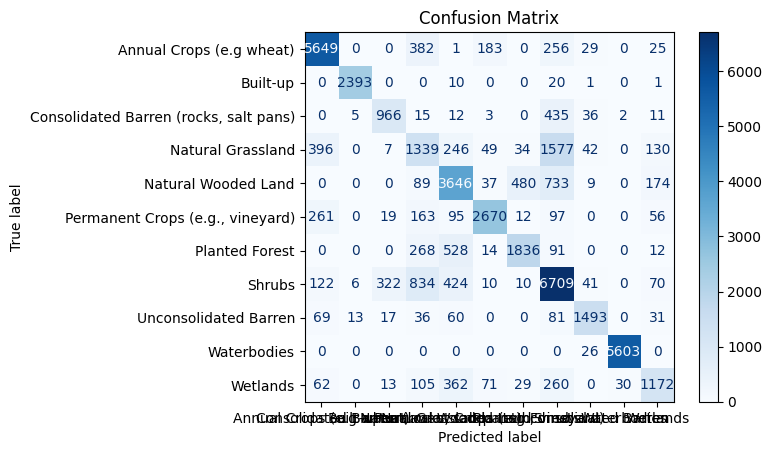

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Fit training data (SVM GridSearch)
accs, f1s = [], []
y_trues, y_preds = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y, groups), 1):
  X_tr, X_va = X[train_idx], X[val_idx]
  y_tr, y_va = y[train_idx], y[val_idx]

  # Fit scaler (fit & transform)
  X_tr = scaler.fit_transform(X_tr)
  X_va = scaler.transform(X_va)

  # Build the MLP model for feature extraction
  modelGS = build_mlpGS(X.shape[1], n_classes = len(np.unique(y)))


  param_grid = {
      'C': [0.1, 1, 10],
      'kernel': ['linear', 'rbf'],
      'gamma': ['scale', 'auto']
  }

  modelGS.fit(X_tr, y_tr, validation_data=(X_va, y_va),
              epochs=100,
              batch_size=32,
              verbose=0)
  # feature_extractor = build_mlpGS(X.shape[1])
  feature_extractor = Model(inputs=modelGS.input,
                            outputs=modelGS.layers[-2].output)

  # Extract features
  X_tr_features = feature_extractor.predict(X_tr)
  X_va_features = feature_extractor.predict(X_va)

  # Logistic Regression
  logreg = LogisticRegression(penalty='l1', solver='liblinear')  # L1 promotes sparsity
  selector = SelectFromModel(logreg)
  selector.fit(X_tr_features, y_tr)

  X_tr_selected = selector.transform(X_tr_features)
  X_va_selected = selector.transform(X_va_features)

  # Train SVM on extracted features
  grid = GridSearchCV(SVC(probability=True), param_grid, cv=3, scoring='f1_macro')
  grid.fit(X_tr_selected, y_tr)

  svm_model = grid.best_estimator_

  # Class weights (optional but helpful if imbalanced)
  classes = np.unique(y_tr)
  cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr)
  class_weight = {int(k): float(v) for k, v in zip(classes, cw)}

  # Evaluate SVM
  y_pred = svm_model.predict(X_va_selected)
  acc = accuracy_score(y_va, y_pred)
  f1 = f1_score(y_va, y_pred, average='macro')
  accs.append(acc); f1s.append(f1)

  # Collect metrics for conf. matrix
  y_trues.extend(y_va)
  y_preds.extend(y_pred)

  print(f"[Fold {fold}]  acc={acc:.4f}  macroF1={f1:.4f}")
  print(classification_report(y_va, y_pred, target_names=le.classes_))

print("==== CV Summary ====")
print(f"Mean Acc: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Mean F1 : {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")

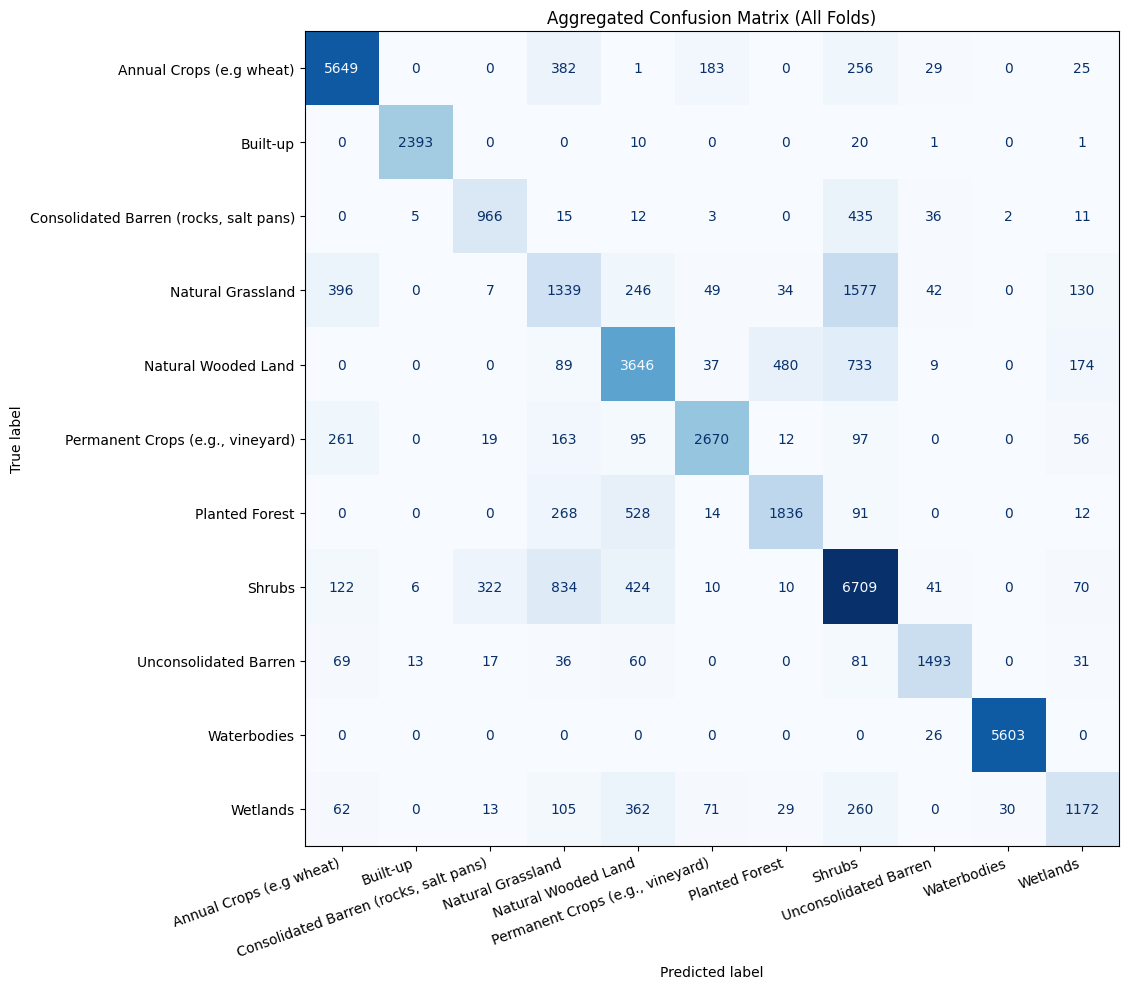

In [ ]:
# Display confusion matrix
cm = confusion_matrix(y_trues, y_preds, labels=np.unique(y))

fig, ax = plt.subplots(figsize=(14, 10))  # make the canvas larger
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", ax=ax, colorbar=False)

# Tilt labels for overlap
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=10)
plt.setp(ax.get_yticklabels(), fontsize=10)

plt.title("Aggregated Confusion Matrix (All Folds)")
plt.tight_layout()
plt.show()

In [ ]:
# Fit testing data (SVM)
accs, f1s = [], []

for fold, (test_idx, val_idx) in enumerate(skf.split(X_test, y_test, groups_test), 1):
    X_ts, X_va = X_test[test_idx], X_test[val_idx]
    y, y_va = y_test[test_idx], y_test[val_idx]

    # Standardize per-fold (transform only)
    X_ts = scaler.transform(X_ts)
    X_va = scaler.transform(X_va)

    # Build the MLP model for feature extraction
    feature_extractor = build_mlp(X_test.shape[1])

    # Extract features
    X_ts_features = feature_extractor.predict(X_ts)
    X_va_features = feature_extractor.predict(X_va)

    # Train SVM on extracted features
    svm_model = SVC(probability=True) # Set probability=True for class weight
    # Class weights (optional but helpful if imbalanced)
    classes = np.unique(y)
    cw = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    class_weight = {int(k): float(v) for k, v in zip(classes, cw)}
    svm_model.fit(X_ts_features, y, sample_weight=compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)[y])


    # Evaluate SVM
    y_pred = svm_model.predict(X_va_features)
    acc = accuracy_score(y_va, y_pred)
    f1 = f1_score(y_va, y_pred, average='macro')
    accs.append(acc); f1s.append(f1)

    print(f"[Fold {fold}]  acc={acc:.4f}  macroF1={f1:.4f}")
    print(classification_report(y_va, y_pred, target_names=le.classes_))

print("==== CV Summary ====")
print(f"Mean Acc: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Mean F1 : {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")

1118/1118 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[Fold 1]  acc=0.7353  macroF1=0.7347
                                        precision    recall  f1-score   support

              Annual Crops (e.g wheat)       0.88      0.80      0.83      1228
                              Built-up       1.00      0.99      1.00       423
Consolidated Barren (rocks, salt pans)       0.73      0.65      0.69       302
                     Natural Grassland       0.37      0.66      0.48       601
                   Natural Wooded Land       0.73      0.61      0.66      1238
      Permanent Crops (e.g., vineyard)       0.79      0.68      0.73       629
                        Planted Forest       0.64      0.72      0.68       603
                                Shrubs       0.58      0.64      0.61      1562
                 Unconsolidated Barren       0.89      0.82      0.85       326
                           Waterbodies       1.00      0.98      0.99      148

1092/1092 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[Fold 1]  acc=0.7672  macroF1=0.7713
                                        precision    recall  f1-score   support

              Annual Crops (e.g wheat)       0.77      0.91      0.83      1264
                              Built-up       1.00      0.98      0.99       390
Consolidated Barren (rocks, salt pans)       0.78      0.95      0.86       234
                     Natural Grassland       0.53      0.29      0.37       853
                   Natural Wooded Land       0.63      0.67      0.65      1011
      Permanent Crops (e.g., vineyard)       0.93      0.72      0.81       648
                        Planted Forest       0.80      0.76      0.78       554
                                Shrubs       0.65      0.78      0.71      1602
                 Unconsolidated Barren       0.92      0.84      0.88       520
                           Waterbodies       0.97      1.00      0.99      116

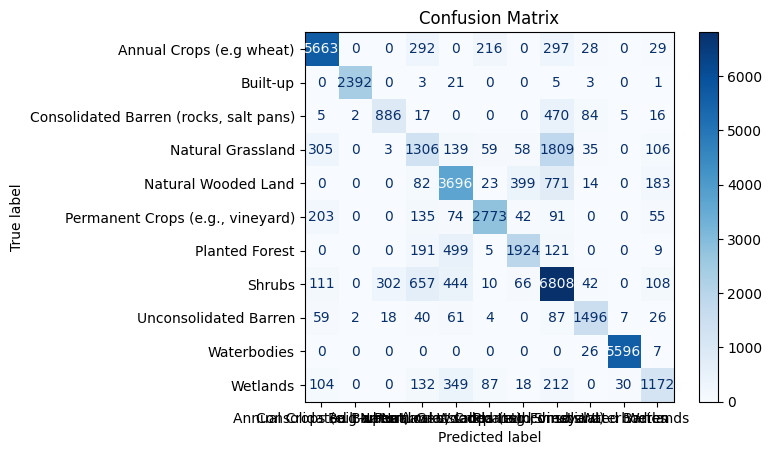

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Fit testing data (SVM GridSearch)
accs, f1s = [], []
y_trues, y_preds = [], []

for fold, (test_idx, val_idx) in enumerate(skf.split(X_test, y_test, groups_test), 1):
  X_ts, X_va = X_test[test_idx], X_test[val_idx]
  y, y_va = y_test[test_idx], y_test[val_idx]

  # Standardize per-fold (transform only)
  X_ts = scaler.transform(X_ts)
  X_va = scaler.transform(X_va)

  # Build the MLP model for feature extraction
  modelGS = build_mlpGS(X.shape[1], n_classes=len(np.unique(y)))

  param_grid = {
      'C': [0.1, 1, 10],
      'kernel': ['linear', 'rbf'],
      'gamma': ['scale', 'auto']
  }

  modelGS.fit(X_ts, y, validation_data=(X_va, y_va),
              epochs=100,
              batch_size=32,
              verbose=0)
  # feature_extractor = build_mlpGS(X.shape[1])
  feature_extractor = Model(inputs=modelGS.input,
                            outputs=modelGS.layers[-2].output)

  # Extract features
  X_ts_features = feature_extractor.predict(X_ts)
  X_va_features = feature_extractor.predict(X_va)

  # Train SVM on extracted features
  grid = GridSearchCV(SVC(probability=True), param_grid, cv=3, scoring='f1_macro')
  grid.fit(X_ts_features, y)

  svm_model = grid.best_estimator_

  # Class weights (balance data)
  classes = np.unique(y)
  cw = compute_class_weight(class_weight='balanced', classes=classes, y=y)
  class_weight = {int(k): float(v) for k, v in zip(classes, cw)}

  # Evaluate SVM
  y_pred = svm_model.predict(X_va_features)
  acc = accuracy_score(y_va, y_pred)
  f1 = f1_score(y_va, y_pred, average='macro')
  accs.append(acc); f1s.append(f1)

  print(f"[Fold {fold}]  acc={acc:.4f}  macroF1={f1:.4f}")
  print(classification_report(y_va, y_pred, target_names=le.classes_))

  # Collect metrics for conf. matrix
  y_trues.extend(y_va)
  y_preds.extend(y_pred)

print("==== CV Summary ====")
print(f"Mean Acc: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Mean F1 : {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")

# Display conf. matrix
cm = confusion_matrix(y_trues, y_preds, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues")
plt.title('Confusion Matrix')
plt.show()

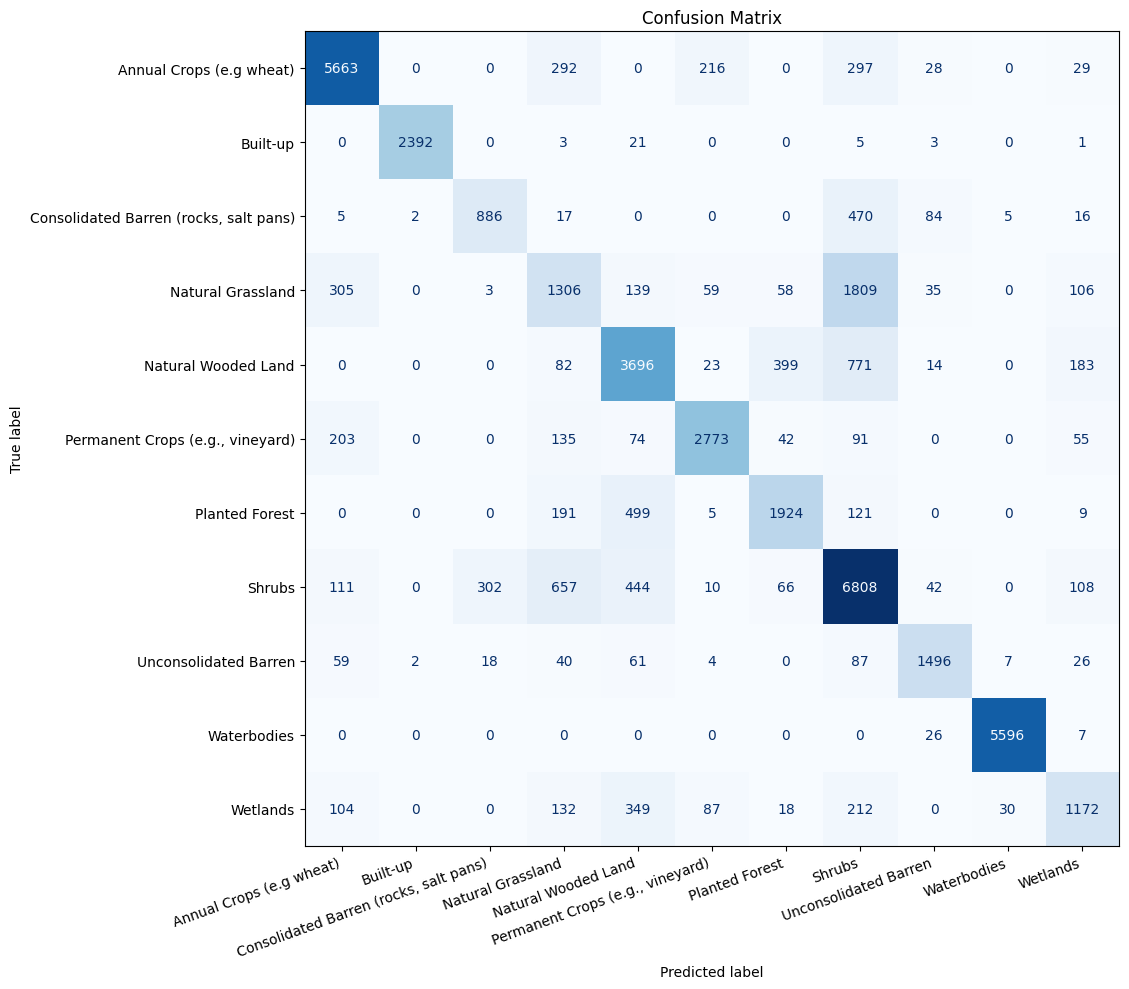

In [ ]:
# Display confusion matrix
cm = confusion_matrix(y_trues, y_preds, labels=np.unique(y))

fig, ax = plt.subplots(figsize=(14, 10))  # make the canvas larger
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", ax=ax, colorbar=False)

# Tilt labels slightly (e.g., 20 degrees) so they don’t overlap
plt.setp(ax.get_xticklabels(), rotation=20, ha="right", fontsize=10)
plt.setp(ax.get_yticklabels(), fontsize=10)

plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:

# ----------------------------- CNN MODEL BELOW ----------------------------- #


In [ ]:
def build_cnn1d(input_dim, n_classes):
    model = models.Sequential([
        layers.Input(shape=(input_dim, 1)),
        layers.Conv1D(64, kernel_size=5, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        layers.MaxPooling1D(pool_size=2),

        layers.Conv1D(128, kernel_size=3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.MaxPooling1D(pool_size=2),

        layers.Conv1D(256, kernel_size=3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.GlobalAveragePooling1D(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# Fit training data (CNN)
accs, f1s = [], []
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y, groups), 1):
    X_tr, X_va = X[train_idx], X[val_idx]
    y_tr, y_va = y[train_idx], y[val_idx]

    # Standardize per-fold (transform only)
    X_tr = scaler.fit_transform(X_tr)
    X_va = scaler.transform(X_va)

    # Reshape for CNN (samples, timesteps, channels)
    X_tr = np.expand_dims(X_tr, -1)
    X_va = np.expand_dims(X_va, -1)

    # Build and train CNN
    model = build_cnn1d(X_tr.shape[1], n_classes=len(np.unique(y)))
    history = model.fit(X_tr, y_tr,
                        validation_data=(X_va, y_va),
                        epochs=50,
                        batch_size=32,
                        verbose=0,
                        callbacks=[
                            tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss', patience=5, restore_best_weights=True)
                        ])

    # Evaluate
    y_pred = np.argmax(model.predict(X_va), axis=1)
    acc = accuracy_score(y_va, y_pred)
    f1 = f1_score(y_va, y_pred, average='macro')
    accs.append(acc); f1s.append(f1)

    print(f"[Fold {fold}] acc={acc:.4f} macroF1={f1:.4f}")
    print(classification_report(y_va, y_pred, target_names=le.classes_))

print("==== CV Summary ====")
print(f"Mean Acc: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Mean F1 : {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")

272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[Fold 1] acc=0.6919 macroF1=0.6633
                                        precision    recall  f1-score   support

              Annual Crops (e.g wheat)       0.86      0.82      0.84      1264
                              Built-up       1.00      0.95      0.98       390
Consolidated Barren (rocks, salt pans)       0.73      0.39      0.51       234
                     Natural Grassland       0.37      0.26      0.31       853
                   Natural Wooded Land       0.61      0.54      0.57      1011
      Permanent Crops (e.g., vineyard)       0.65      0.72      0.68       648
                        Planted Forest       0.62      0.48      0.54       554
                                Shrubs       0.55      0.82      0.65      1602
                 Unconsolidated Barren       0.95      0.74      0.83       520
                           Waterbodies       0.97      1.00      0.98      1163
                              Wetlands     

In [ ]:
# --- Save final model trained on full data (optional) ---
# Refit scaler on all data, train for a few epochs:
scaler_full = StandardScaler().fit(X)
X_full = scaler_full.transform(X)
if USE_CNN:
    model_full = build_cnn1d(X.shape[1], n_classes)
    X_full_in = X_full[..., None]
else:
    model_full = build_mlp(X.shape[1], n_classes)
    X_full_in = X_full

model_full.fit(X_full_in, y, epochs=20, batch_size=256, verbose=0, class_weight=class_weight)
model_full.save('/content/embedding_mlp.h5')
import joblib, os
joblib.dump({'scaler': scaler_full, 'label_encoder': le}, '/content/embedding_mlp_assets.pkl')
print("Saved /content/embedding_mlp.h5 and /content/embedding_mlp_assets.pkl")

NameError: name 'USE_CNN' is not defined